In [4]:
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jnp
import jax
from tqdm import tqdm
from h5py import File
from numpyro.infer import MCMC, NUTS, init_to_median, util
import corner
from copy import copy
from getdist import plots, MCSamples
import getdist

import csiborgtools

from flow_calibration import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## LOS density & radial velocity plots 

In [14]:
# fpath = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"
fpath = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"

loader_carrick = csiborgtools.flow.DataLoader("Carrick2015", "LOSS", fpath, paths, ksmooth=0)
loader_csiborg = csiborgtools.flow.DataLoader("csiborg1", "LOSS", fpath, paths, ksmooth=0)
loader_csiborg2 = csiborgtools.flow.DataLoader("csiborg2_main", "LOSS", fpath, paths, ksmooth=0)

10:20:19: reading the catalogue.
10:20:19: reading the interpolated field.


100%|██████████| 1/1 [00:00<00:00, 84.48it/s]


10:20:19: calculating the radial velocity.


100%|██████████| 50/50 [00:00<00:00, 21608.99it/s]


10:20:19: reading the catalogue.
10:20:19: reading the interpolated field.


100%|██████████| 101/101 [00:02<00:00, 42.58it/s]


10:20:21: calculating the radial velocity.


100%|██████████| 50/50 [00:00<00:00, 351.66it/s]


10:20:22: reading the catalogue.
10:20:22: reading the interpolated field.


100%|██████████| 20/20 [00:00<00:00, 123.83it/s]


10:20:22: calculating the radial velocity.


100%|██████████| 50/50 [00:00<00:00, 1285.41it/s]


In [2]:
# ks = [115,  53,  77, 105,  26,  61,  86,  29,  80,  21]
ks = [19,  8, 15,  0, 16,  6, 48, 38, 26, 44]
# ks = [19]
# ks = np.random.choice(50, 10, replace=False)

# k = 6
for k in []:
    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    # Get rid of vertical spacing
    fig.subplots_adjust(wspace=0)

    # Plot CSiBORG
    for i in range(loader_csiborg.los_density.shape[1]):
        axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, i, :], alpha=0.1, color="black")
        axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, i, :], alpha=0.1, color="black")

    # CSiBORG1
    axs[0].plot(loader_csiborg.rdist, loader_csiborg.los_density[k, :, :].mean(axis=0), color="red", label="CSiBORG1")
    axs[1].plot(loader_csiborg.rdist, loader_csiborg.los_radial_velocity[k, :, :].mean(axis=0), color="red")

    # CSiBORG2
    axs[0].plot(loader_csiborg2.rdist, loader_csiborg2.los_density[k, :, :].mean(axis=0), color="violet", label="CSiBORG2")
    axs[1].plot(loader_csiborg2.rdist, loader_csiborg2.los_radial_velocity[k, :, :].mean(axis=0), color="violet")

    # Plot Carrick+2015
    axs[0].plot(loader_carrick.rdist, loader_carrick.los_density[k, 0, :], color="blue", label="Carrick+2015")
    axs[1].plot(loader_carrick.rdist, loader_carrick.los_radial_velocity[k, 0, :] * 0.43, color="blue")


    # for i in range(2):
    #     label = "SN"
    #     rdist = loader_csiborg.cat["r_hMpc"][k]
    #     axs[i].axvline(rdist, color="violet", linestyle="--",
    #                 zorder=0, label=label)

    axs[1].set_xlabel(r"$r ~ [\mathrm{Mpc} / h]$")
    axs[0].set_ylabel(r"$\rho_{\rm LOS} / \langle \rho_{\rm matter} \rangle$")
    axs[1].set_ylabel(r"$v_{\rm LOS} ~ [\mathrm{km/s}]$")

    axs[0].set_yscale("log")

    axs[0].legend(loc="upper right")
    axs[0].set_xlim(0, 200)

    fig.tight_layout(w_pad=0, h_pad=0)
    fig.savefig(f"../plots/LOSS_los_{k}.png", dpi=500, bbox_inches="tight")

    fig.show()

## Test running a model

In [396]:
fpath_data = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation_Supranta2019.hdf5"
# fpath_data = "/mnt/extraspace/rstiskalek/catalogs/A2.h5"

simname = "Carrick2015"
catalogue = "LOSS"
loader = csiborgtools.flow.DataLoader(simname, 0, catalogue, fpath_data, paths, ksmooth=0)
get_model_kwargs = {"zcmb_max": 0.06}

17:23:04: reading the catalogue.
17:23:04: reading the interpolated field.
17:23:04: calculating the radial velocity.


#### Running HMC

In [399]:
model = csiborgtools.flow.get_model(loader, **get_model_kwargs)

Selected 50/50 galaxies.


In [400]:
kernel = NUTS(model, init_strategy=init_to_median(num_samples=100))
mcmc = MCMC(kernel, num_warmup=250, num_samples=2500)

rng_key = jax.random.PRNGKey(5)

In [401]:
model_kwargs = {"sample_alpha": True}
mcmc.run(rng_key, **model_kwargs)

sample: 100%|██████████| 2750/2750 [00:32<00:00, 84.40it/s, 7 steps of size 4.13e-01. acc. prob=0.91]  


In [404]:
mcmc.print_summary()
samples = mcmc.get_samples(group_by_chain=False)
print(csiborgtools.numpyro_gof(model, mcmc, len(loader.cat), model_kwargs))


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
          Vext_x    -16.69     75.95    -15.21   -132.91    118.30   1460.49      1.00
          Vext_y    -24.01    105.18    -28.09   -188.07    154.02   1522.27      1.00
          Vext_z    -88.49    152.80    -89.86   -341.05    169.93   1303.93      1.00
           alpha      1.01      0.39      0.95      0.40      1.61   2728.86      1.00
       alpha_cal      0.13      0.02      0.13      0.09      0.17   2106.27      1.00
            beta      0.44      0.11      0.45      0.28      0.62   2280.95      1.00
        beta_cal      3.53      0.19      3.53      3.21      3.83   1598.26      1.00
  e_mu_intrinsic      0.09      0.03      0.08      0.04      0.12   1790.78      1.00
         mag_cal    -18.19      0.04    -18.20    -18.26    -18.13   1351.76      1.00
         sigma_v    181.29     55.02    175.90     93.08    265.91   1889.45      1.00

Number of divergences: 0


In [348]:
Vmag = np.sqrt(samples["Vext_x"]**2 + samples["Vext_y"]**2 + samples["Vext_z"]**2)

V = np.vstack([samples["Vext_x"], samples["Vext_y"], samples["Vext_z"]]).T
V = csiborgtools.cartesian_to_radec(V)

l, b = csiborgtools.flow.radec_to_galactic(V[:, 1], V[:, 2])

print(f"|V|  = {np.mean(Vmag)} +- {np.std(Vmag)}")
print(f"l    = {np.mean(l)} +- {np.std(l)}")
print(f"b    = {np.mean(b)} +- {np.std(b)}")
print(f"beta = {np.mean(samples['beta'])} +- {np.std(samples['beta'])}")

In [352]:
if "alpha" in samples:
    data = np.vstack([samples["alpha"], samples["beta"], l, b, Vmag]).T
    labels = [r"$\alpha$", r"$\beta$", r"$l$", r"$b$", r"$|\bf{V}_{\rm ext}|$"]
else:
    data = np.vstack([samples["beta"], l, b, Vmag]).T
    labels = [r"$\beta$", r"$l$", r"$b$", r"$|\bf{V}_{\rm ext}|$"]

fig = corner.corner(data, labels=labels, show_titles=True, title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)

## Vizualize the results

####  Functions to read in the results

Reading 2MTF fitted to Carrick2015 with ksmooth = 0.
BIC  = 19517.031250 +- 0.000000
AIC  = 19470.867188 +- 0.000000
logZ = -9731.227539 +- 0.000000



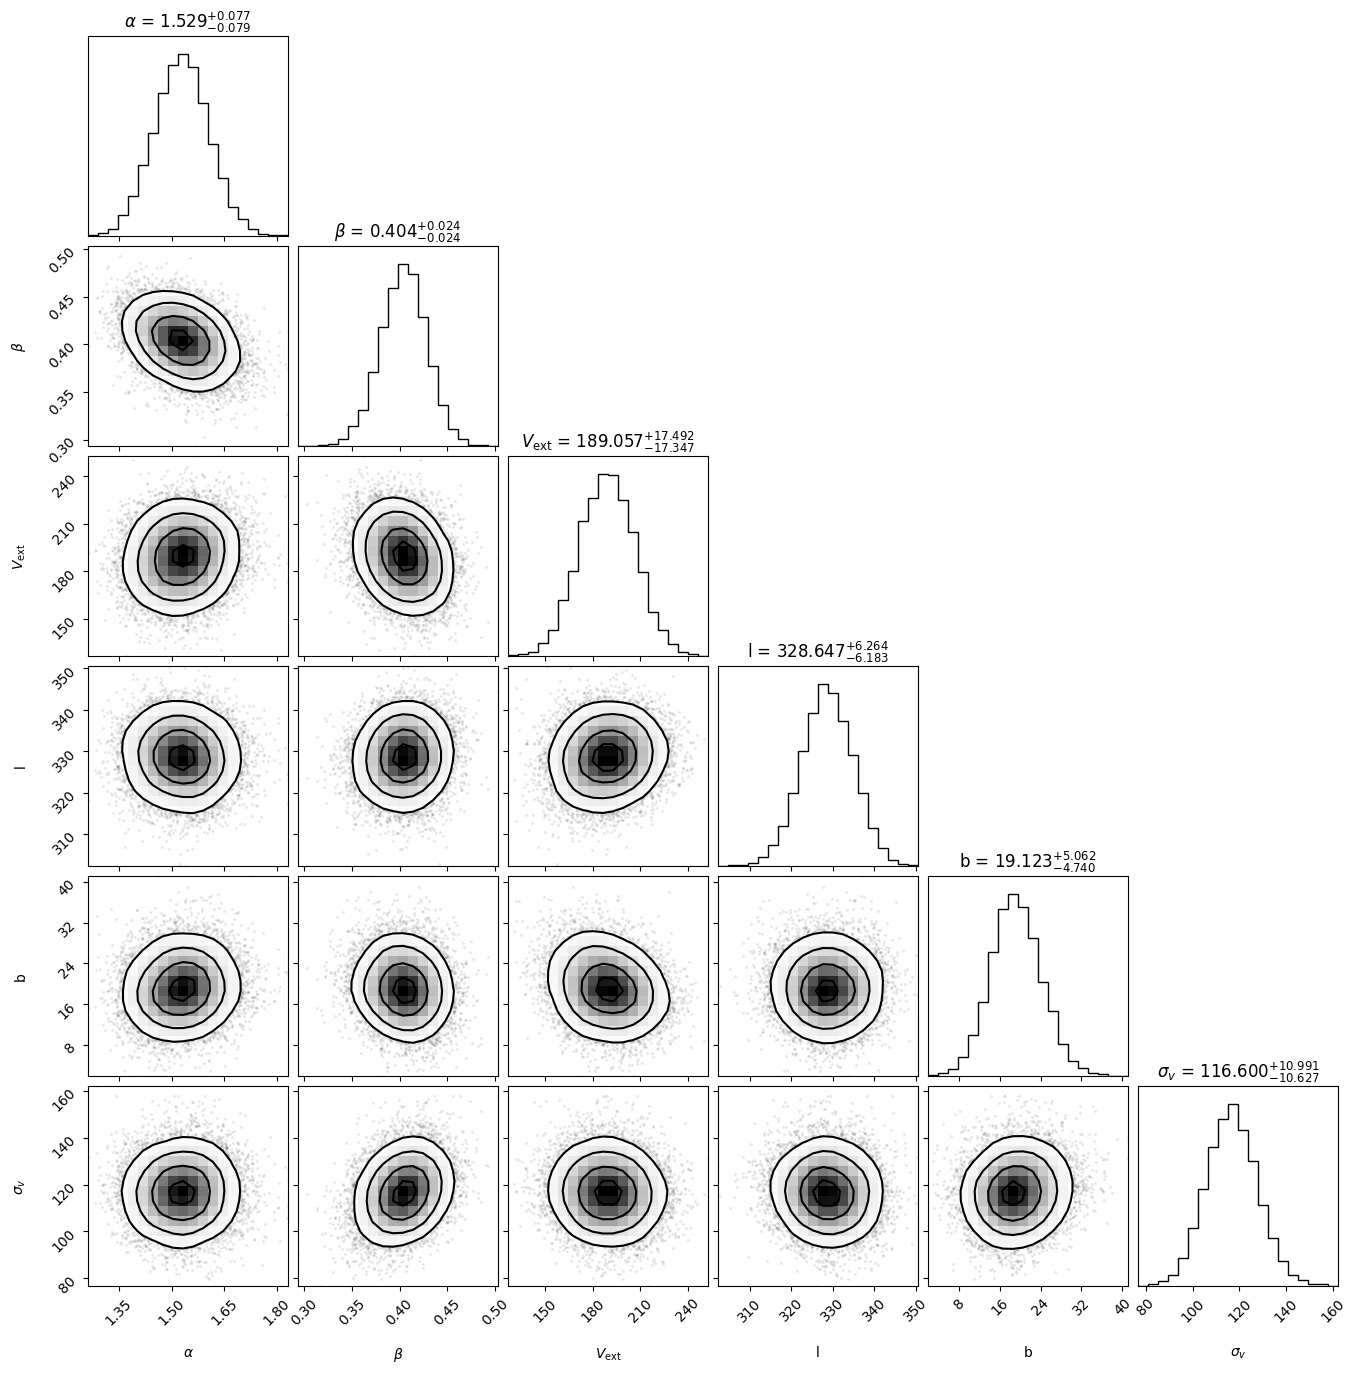

In [10]:
data, names, gof = read_samples("2MTF", "Carrick2015", 0)

fig = corner.corner(data, labels=names_to_latex(names, True), show_titles=True,
                    title_fmt=".3f", title_kwargs={"fontsize": 12}, smooth=1)

### LOSS-only comparison

In [24]:
LOSS_Carrick_0 = read_samples("LOSS", "Carrick2015", 0, return_MCsamples=True)
LOSS_Carrick_1 = read_samples("LOSS", "Carrick2015", 1, return_MCsamples=True)

# LOSS_CB1_0 = read_samples("LOSS", "csiborg1", 0, return_MCsamples=True)
# LOSS_CB1_1 = read_samples("LOSS", "csiborg1", 1, return_MCsamples=True)

# LOSS_CB2_0 = read_samples("LOSS", "csiborg2_main", 0, return_MCsamples=True)
# LOSS_CB2_1 = read_samples("LOSS", "csiborg2_main", 1, return_MCsamples=True)


Reading LOSS fitted to Carrick2015 with ksmooth = 0.
BIC  = 773.225037 +- 0.000000
AIC  = 754.104797 +- 0.000000
logZ = -356.240234 +- 0.000000
Removed no burn in

Reading LOSS fitted to Carrick2015 with ksmooth = 1.
BIC  = 775.741028 +- 0.000000
AIC  = 756.620789 +- 0.000000
logZ = -357.095551 +- 0.000000
Removed no burn in


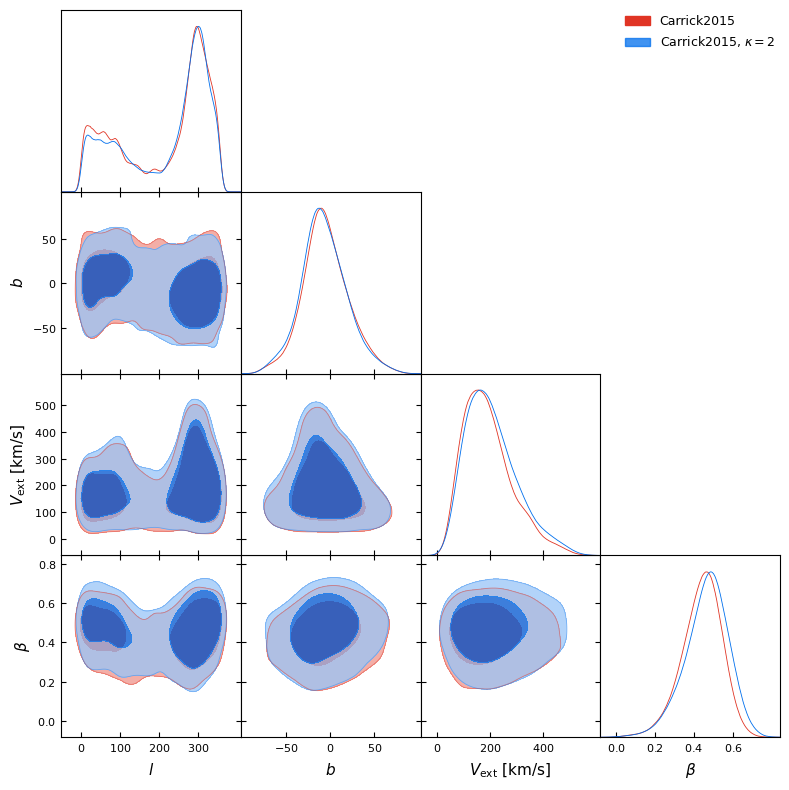

In [32]:
X = [
     LOSS_Carrick_0,
     LOSS_Carrick_1,
     # LOSS_CB1_0,
     # LOSS_CB1_1,
     # LOSS_CB2_0,
     # LOSS_CB2_1,
     ]

# params = ["l", "b", "Vmag", "beta"]
params = None

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, params=params, filled=True, legend_loc='upper right', )
# g.export(f"../plots/LOSS_comparison.png", dpi=500,)


### Foundation-only comparison

In [18]:
FOUNDATION_Carrick_0 = read_samples("Foundation", "Carrick2015", 0, return_MCsamples=True)
FOUNDATION_Carrick_1 = read_samples("Foundation", "Carrick2015", 1, return_MCsamples=True)

FOUNDATION_CB1_0 = read_samples("Foundation", "csiborg1", 0, return_MCsamples=True)
FOUNDATION_CB1_1 = read_samples("Foundation", "csiborg1", 1, return_MCsamples=True)

FOUNDATION_CB2_0 = read_samples("Foundation", "csiborg2_main", 0, return_MCsamples=True)
FOUNDATION_CB2_1 = read_samples("Foundation", "csiborg2_main", 1, return_MCsamples=True)


Reading Foundation fitted to Carrick2015 with ksmooth = 0.
BIC  = 1852.867188 +- 0.000000
AIC  = 1824.664429 +- 0.000000
logZ = -897.537476 +- 0.000000
Removed no burn in

Reading Foundation fitted to Carrick2015 with ksmooth = 1.
BIC  = 1855.804321 +- 0.000000
AIC  = 1827.601562 +- 0.000000
logZ = -899.147217 +- 0.000000
Removed no burn in

Reading Foundation fitted to csiborg1 with ksmooth = 0.
BIC  = 1874.444986 +- 5.030578
AIC  = 1846.242227 +- 5.030578
logZ = -909.946525 +- 2.405679
Removed no burn in

Reading Foundation fitted to csiborg1 with ksmooth = 1.
BIC  = 1871.209213 +- 4.486214
AIC  = 1843.006454 +- 4.486214
logZ = -907.345996 +- 2.270922
Removed no burn in

Reading Foundation fitted to csiborg2_main with ksmooth = 0.
BIC  = 1862.151703 +- 5.628656
AIC  = 1833.948944 +- 5.628656
logZ = -902.754858 +- 2.689162
Removed no burn in

Reading Foundation fitted to csiborg2_main with ksmooth = 1.
BIC  = 1861.102936 +- 2.733637
AIC  = 1832.900177 +- 2.733637
logZ = -901.194189 +

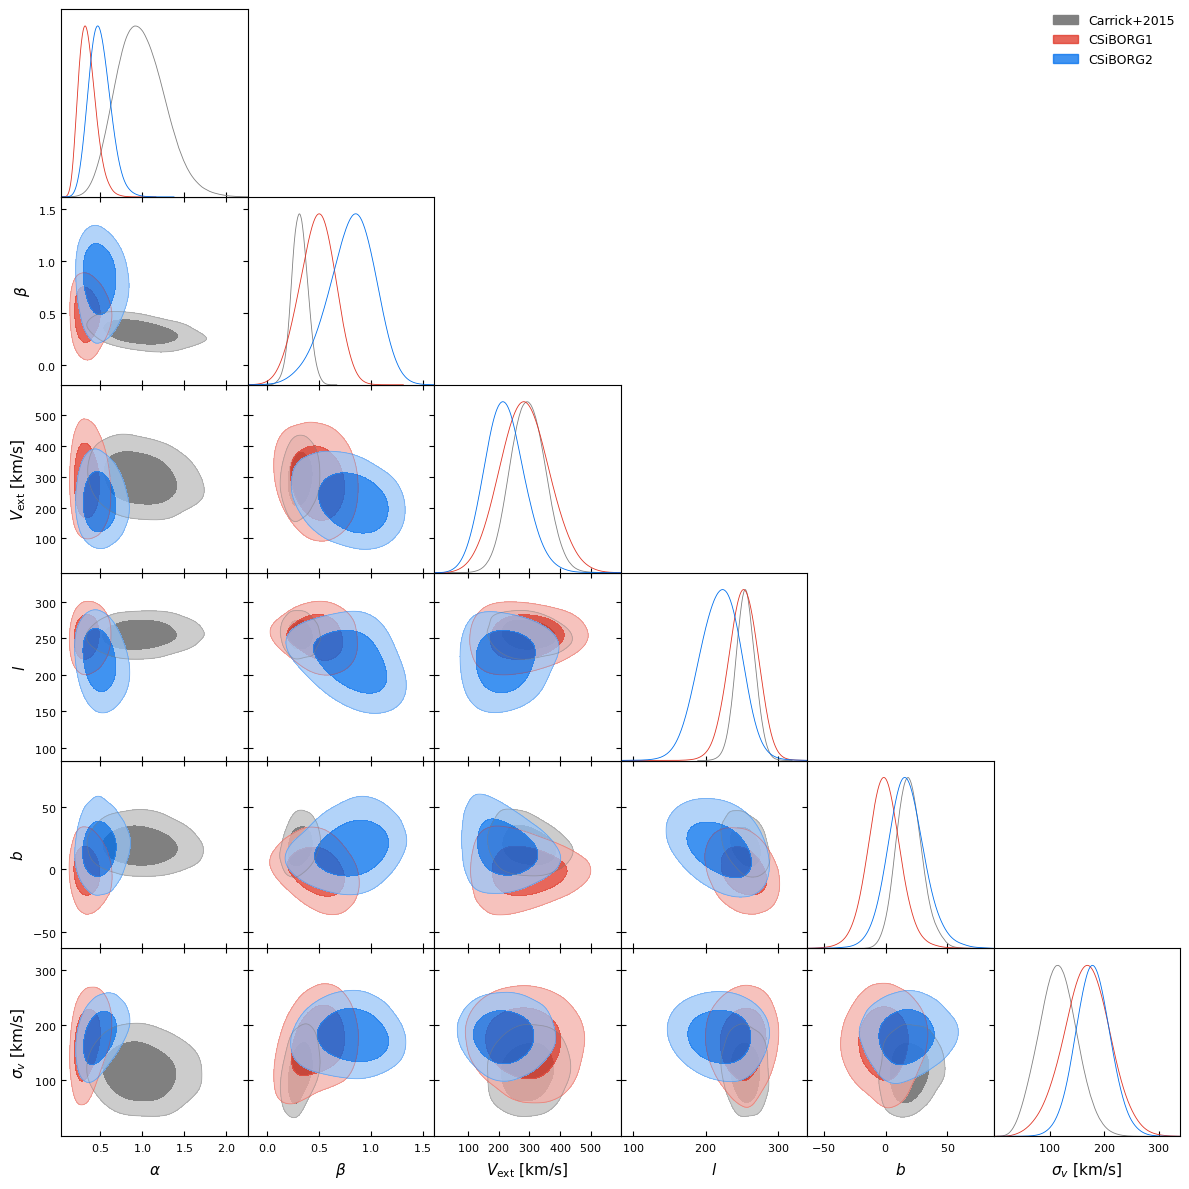

In [128]:
X = [
    FOUNDATION_Carrick_0,
    # FOUNDATION_Carrick_1,
    FOUNDATION_CB1_0,
    # FOUNDATION_CB1_1,
    FOUNDATION_CB2_0,
    # FOUNDATION_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')
g.export(f"../plots/FOUNDATION_comparison.png", dpi=500,)

### PantheonPlus-only comparison

In [22]:
PANTHEONP_Carrick_0 = read_samples("Pantheon+", "Carrick2015", 0, return_MCsamples=True)
PANTHEONP_Carrick_1 = read_samples("Pantheon+", "Carrick2015", 1, return_MCsamples=True)

PANTHEONP_CB1_1 = read_samples("Pantheon+", "csiborg1", 1, return_MCsamples=True)



Reading Pantheon+ fitted to Carrick2015 with ksmooth = 0.
BIC  = 9947.804688 +- 0.000000
AIC  = 9902.613281 +- 0.000000
logZ = -4942.983398 +- 0.000000
Removed no burn in

Reading Pantheon+ fitted to Carrick2015 with ksmooth = 1.


BIC  = 9990.192383 +- 0.000000
AIC  = 9945.000977 +- 0.000000
logZ = -4963.845215 +- 0.000000
Removed no burn in

Reading Pantheon+ fitted to csiborg1 with ksmooth = 1.
BIC  = 10165.647413 +- 17.567630
AIC  = 10120.456006 +- 17.567630
logZ = -5050.821265 +- 8.730728
Removed no burn in


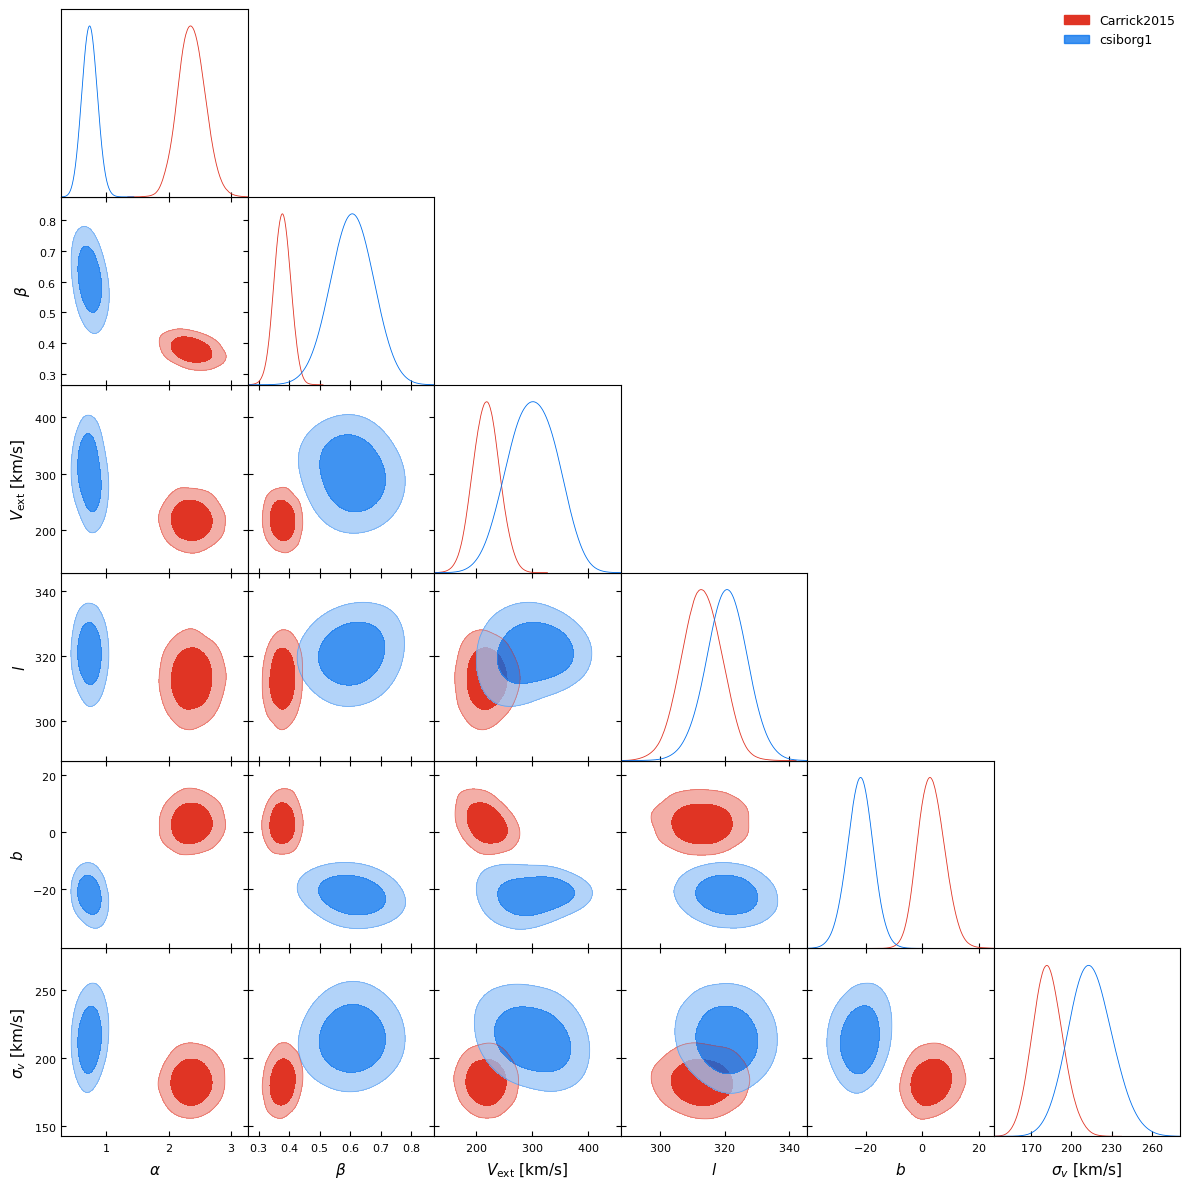

In [23]:
X = [
    # PANTHEONP_Carrick_0,
    PANTHEONP_Carrick_1,
    PANTHEONP_CB1_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')

### 2MTF comparison

In [20]:
TWOMTF_Carrick_0 = read_samples("2MTF", "Carrick2015", 0, return_MCsamples=True)
TWOMTF_Carrick_1 = read_samples("2MTF", "Carrick2015", 1, return_MCsamples=True)

TWOMTF_CB2_0 = read_samples("2MTF", "csiborg2_main", 0, return_MCsamples=True)
TWOMTF_CB2_1 = read_samples("2MTF", "csiborg2_main", 1, return_MCsamples=True)


Reading 2MTF fitted to Carrick2015 with ksmooth = 0.
BIC  = 19517.031250 +- 0.000000
AIC  = 19470.867188 +- 0.000000
logZ = -9731.227539 +- 0.000000
Removed no burn in

Reading 2MTF fitted to Carrick2015 with ksmooth = 1.
BIC  = 19632.685547 +- 0.000000
AIC  = 19586.521484 +- 0.000000
logZ = -9788.892578 +- 0.000000
Removed no burn in

Reading 2MTF fitted to csiborg2_main with ksmooth = 0.


BIC  = 19248.799609 +- 38.583873
AIC  = 19202.635547 +- 38.583873
logZ = -9598.394336 +- 19.251815
Removed no burn in

Reading 2MTF fitted to csiborg2_main with ksmooth = 1.
BIC  = 19167.596582 +- 20.190445
AIC  = 19121.432520 +- 20.190445
logZ = -9555.558252 +- 9.820362
Removed no burn in


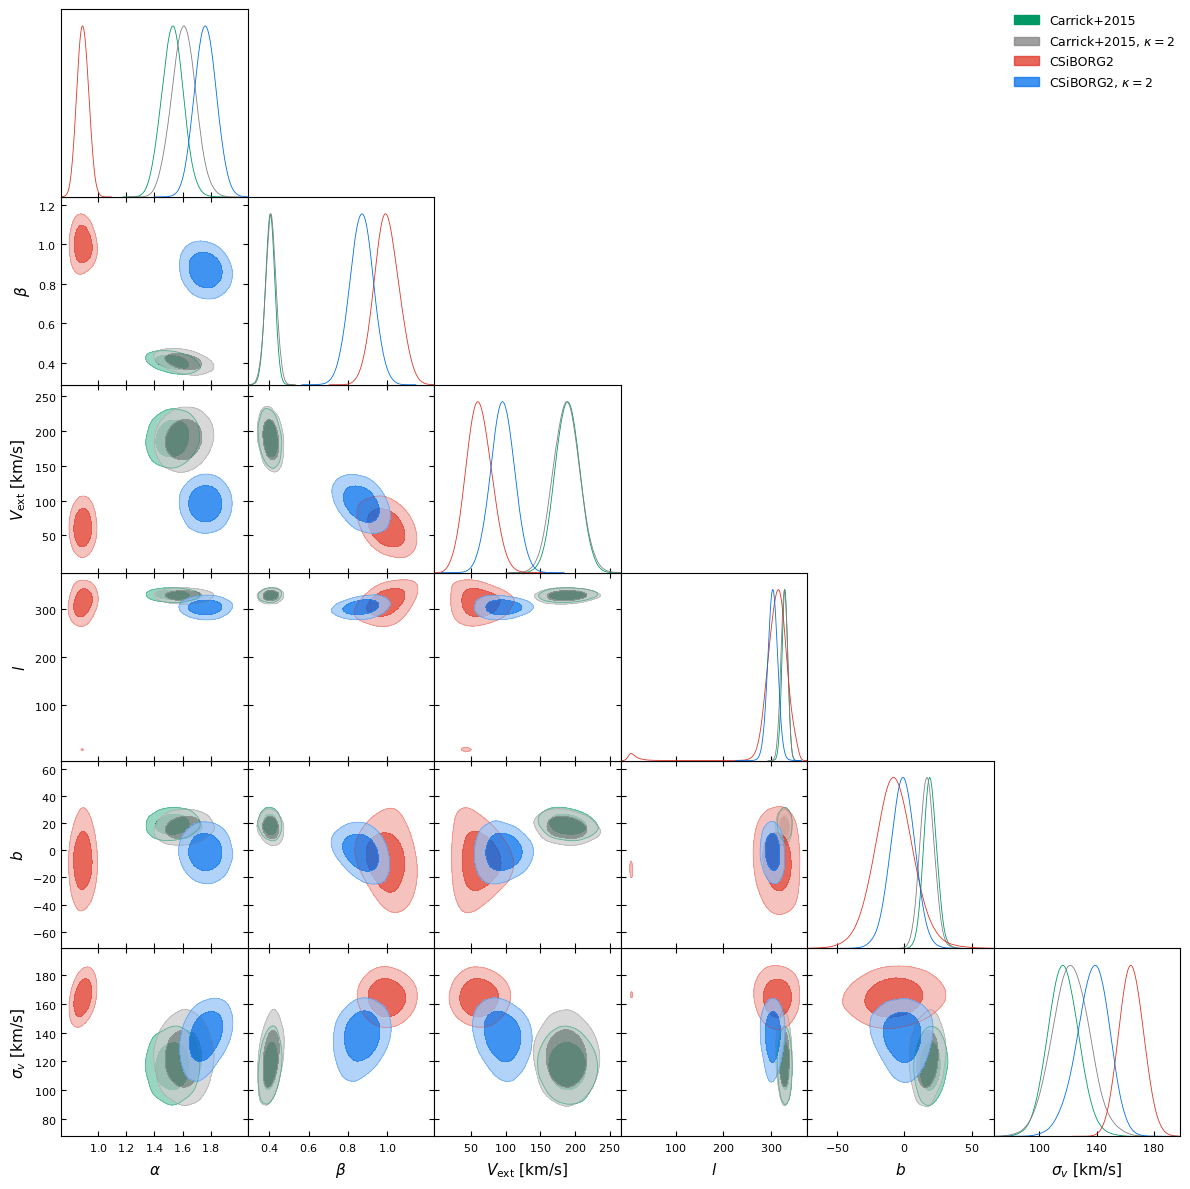

In [18]:
X = [
    TWOMTF_Carrick_0,
    TWOMTF_Carrick_1,
    TWOMTF_CB2_0,
    TWOMTF_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')

### SFI galaxies

In [21]:
SFIGAL_Carrick_0 = read_samples("SFI_gals", "Carrick2015", 0, return_MCsamples=True)
SFIGAL_Carrick_1 = read_samples("SFI_gals", "Carrick2015", 1, return_MCsamples=True)

SFIGAL_CB2_0 = read_samples("SFI_gals", "csiborg2_main", 0, return_MCsamples=True)
SFIGAL_CB2_1 = read_samples("SFI_gals", "csiborg2_main", 1, return_MCsamples=True)


Reading SFI_gals fitted to Carrick2015 with ksmooth = 0.
BIC  = 28854.421875 +- 0.000000
AIC  = 28805.011719 +- 0.000000
logZ = -14392.536133 +- 0.000000
Removed no burn in

Reading SFI_gals fitted to Carrick2015 with ksmooth = 1.
BIC  = 28930.990234 +- 0.000000
AIC  = 28881.580078 +- 0.000000
logZ = -14433.558594 +- 0.000000
Removed no burn in

Reading SFI_gals fitted to csiborg2_main with ksmooth = 0.
BIC  = 28779.863770 +- 42.922014
AIC  = 28730.453613 +- 42.922014
logZ = -14356.845068 +- 21.362802
Removed no burn in

Reading SFI_gals fitted to csiborg2_main with ksmooth = 1.
BIC  = 28646.324902 +- 24.227278
AIC  = 28596.914746 +- 24.227278
logZ = -14288.365332 +- 12.050230
Removed no burn in


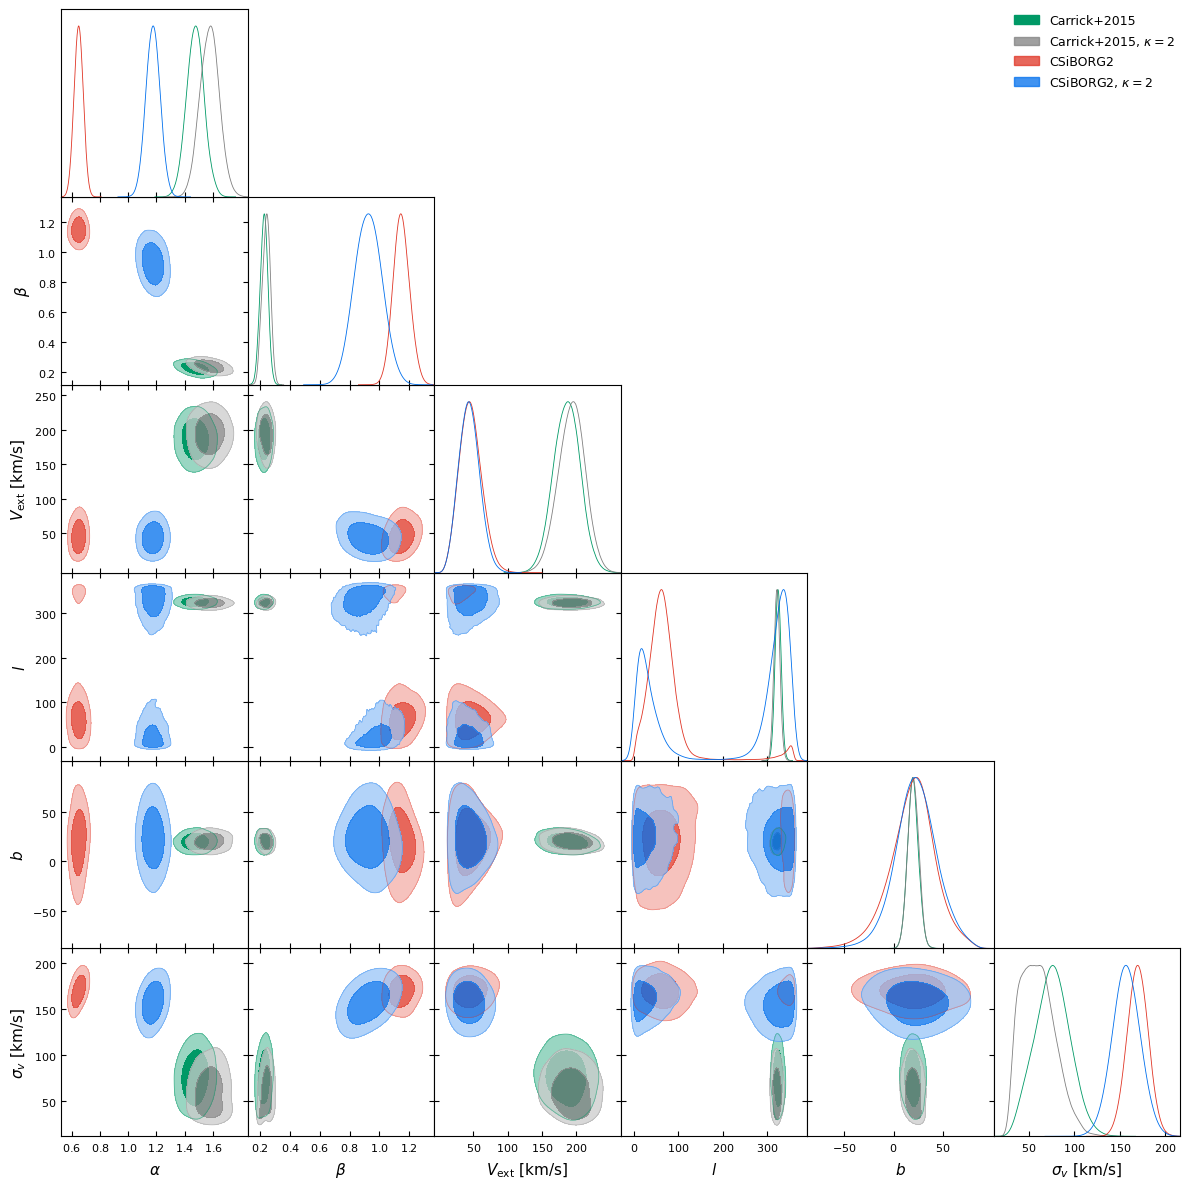

In [14]:
X = [
    SFIGAL_Carrick_0,
    SFIGAL_Carrick_1,
    SFIGAL_CB2_0,
    SFIGAL_CB2_1,
    ]

g = plots.get_subplot_plotter()
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.75
# g.settings.title_limit_fontsize = 14
g.triangle_plot(X, filled=True, legend_loc='upper right')